In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

output_path = '/home/FRACTAL/shaheen.perveen/stage3/model_outputs/ela_resnext101_64/'
input_path = '/home/FRACTAL/shaheen.perveen/stage3/fakers/stage-3/stage3_image_data/train/train_ela/'

import os
os.chdir('/home/FRACTAL/shaheen.perveen/fastai/old')
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from pathlib import *
import pandas as pd
import numpy as np

#checking wheteher cuda and cudnn are available. Cuda is necessary & Cudnn is optional, it makes computation faster
torch.cuda.is_available()

torch.backends.cudnn.enabled

#using  device 0-gpu
torch.cuda.set_device(0)
torch.cuda.current_device()

labels_model = pd.read_csv(input_path+"label_csv.csv")

labels = labels_model[['class']]
# print(labels.head(1))

labels['class'] = np.where(labels['class'] == 'real',1,0)
# print(labels.head(1))

# print(labels.describe())


def get_data(f_model,sz,bs,val_idxs,aug_tfms,root_path,train_folder,label_csv,test_folder,skip_header,augmentation_required):
    if (augmentation_required):
        tfms = tfms_from_model(f_model, sz,aug_tfms=aug_tfms,max_zoom=1.1)
    else:
        tfms =  tfms_from_model(f_model, sz)
    
    label_csv.to_csv(str(root_path)+'temp_label_file.csv',index=False)
    
    return ImageClassifierData.from_csv(root_path, train_folder,str(root_path)+'temp_label_file.csv',bs=bs,tfms=tfms,
                     val_idxs=val_idxs,test_name=test_folder,skip_header=skip_header)

def exp_name(output_path,freeze,model_name,lrn,sz):
    return output_path+freeze+'_'+'_'+model_name+'_lr'+str(lrn)+'_sz'+str(sz)

label_csv = labels_model.copy()
#a root path of the data (used for storing trained models, precomputed values, etc)
root_path=('/home/FRACTAL/shaheen.perveen/stage3/temp_model_parameters/')
#a name of the folder in which training images are contained.
train_folder = ('')
#a name of the folder which contains test images.
test_folder= ('/home/FRACTAL/shaheen.perveen/stage3/fakers/stage-3/stage3_image_data/test/test')

#for generating the validation indexes
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1729)
labels_splits = labels.copy()
X= labels['class'].astype(int)
y=labels['class'].astype(int)

for train_index, test_index in sss.split(X, y):
    trn_indx = train_index
    val_idxs = test_index

f_model=resnext101_64
sz=224
aug_tfms=transforms_side_on
max_zoom=1.1
bs=4
#use this if we dont need augmentation
augmentation_required = True

model_name=str(f_model).split(' ')[1]


/home/FRACTAL/shaheen.perveen/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [2]:
#making data object
data = get_data(f_model,sz,bs,val_idxs,aug_tfms,root_path,train_folder,label_csv,test_folder,skip_header=True,augmentation_required=augmentation_required)

In [3]:
learn = ConvLearner.pretrained(f_model, data,precompute=False)

In [4]:
lrn=8e-5

In [5]:
from sklearn.metrics import f1_score
import warnings
def f1(log_preds, targs, start=0.1, end=0.8, step=0.1):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        pos_predss = torch.exp(log_preds) 
        return max([f1_score(targs, torch.max(pos_predss > th, dim=1)[1], average='weighted')
                    for th in np.arange(start,end,step)])

In [6]:
exp_name(output_path,'frz',model_name,lrn,sz)

'/home/FRACTAL/shaheen.perveen/stage3/model_outputs/ela_resnext101_64/frz__resnext101_64_lr8e-05_sz224'

In [7]:
# #
# sz=224
# learn.load(exp_name(output_path,'unfrz',model_name,lrn,sz))
# learn.freeze()

sz=400
# #making data object
data = get_data(f_model,sz,bs,val_idxs,aug_tfms,root_path,train_folder,label_csv,test_folder,skip_header=True,augmentation_required=augmentation_required)
learn.set_data(data)



# lrn=8e-5

# learn.fit(lrn, 3, cycle_len=1, cycle_mult=2, metrics=[accuracy, f1])

# learn.save(exp_name(output_path,'frz',model_name,lrn,sz))
#loading the previous saved model and unfreezing the network for more training
learn.load(exp_name(output_path,'frz',model_name,lrn,sz))
learn.unfreeze()
learn.bn_freeze(True)

lr=np.array([lrn/100,lrn/10,lrn])

learn.fit(lr, 2, cycle_len=1,cycle_mult=2, metrics=[accuracy, f1],cycle_save_name=exp_name(output_path,'unfrz',model_name,lrn,sz))
learn.save(exp_name(output_path,'unfrz',model_name,lrn,sz))


epoch      trn_loss   val_loss   accuracy   f1                   
    0      0.444185   0.415237   0.809516   0.970596  
    1      0.45365    0.411136   0.813856   0.971305             
    2      0.37708    0.404905   0.816646   0.969144             



In [8]:
#
learn.load(exp_name(output_path,'unfrz',model_name,lrn,sz))
learn.freeze()

sz=512
#making data object
data = get_data(f_model,sz,bs,val_idxs,aug_tfms,root_path,train_folder,label_csv,test_folder,skip_header=True,augmentation_required=augmentation_required)
learn.set_data(data)



lrn=8e-5

learn.fit(lrn, 3, cycle_len=1, cycle_mult=2,metrics=[accuracy, f1],cycle_save_name=exp_name(output_path,'frz',model_name,lrn,sz))

learn.save(exp_name(output_path,'frz',model_name,lrn,sz))

#loading the previous saved model and unfreezing the network for more training
learn.load(exp_name(output_path,'frz',model_name,lrn,sz))
learn.unfreeze()
learn.bn_freeze(True)

lr=np.array([lrn/100,lrn/10,lrn])

learn.fit(lr, 2, cycle_len=1,cycle_mult=2,metrics=[accuracy, f1],cycle_save_name=exp_name(output_path,'unfrz',model_name,lrn,sz))
learn.save(exp_name(output_path,'unfrz',model_name,lrn,sz))

epoch      trn_loss   val_loss   accuracy   f1                   
    0      0.430364   0.407495   0.811066   0.966026  
    1      0.43565    0.406385   0.811996   0.965979             
    2      0.466842   0.40581    0.810911   0.966481             
    3      0.418545   0.405263   0.812461   0.969427             
    4      0.404108   0.402967   0.813081   0.963345             
    5      0.396817   0.403587   0.812151   0.967591             
    6      0.393086   0.403139   0.812926   0.966953             



epoch      trn_loss   val_loss   accuracy   f1                   
    0      0.406731   0.401046   0.816336   0.969941  
    1      0.416449   0.399571   0.815561   0.970507             
    2      0.412231   0.395944   0.818351   0.96798              



 34%|███▎      | 2162/6452 [24:51<1:16:55,  1.08s/it, loss=1.24] 

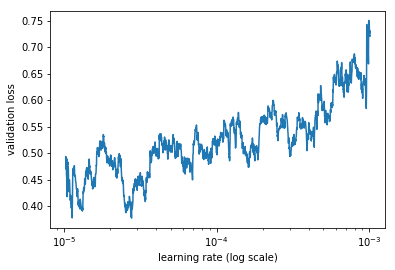

In [9]:
lrf=learn.lr_find()

learn.sched.plot()

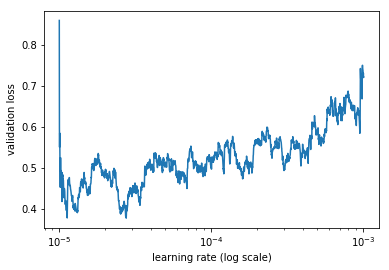

In [10]:
learn.sched.plot(n_skip=0)

In [11]:
lrn=1e-6

learn.fit(lrn, 1, cycle_len=1, cycle_mult=2,metrics=[accuracy, f1])


 19%|█▉        | 1256/6452 [13:10<50:23,  1.72it/s, loss=0.445]  

KeyboardInterrupt: 